### Project Task 2 - Advanced Classifiers and Evaluation
- Using the dataset for classification prepared for Task 1 build several advanced classifiers able to predict room occupancy from the available variables. In particular, you are required to use SVM (linear and non-linear), NN (Single and Multilayer Perceptron), DNN (design at least two different architectures), Ensemble Classifier (RandomForest, AdaBoost and a Bagging technique in which you can select a base classifier of your choice with a justification).
- Evaluate each classifier using Accuracy, Precision, Recall, F1, ROC, etc; Draw your conclusion about the classifiers.
- Highlight in the report different aspects typical of each classifier. For instance for SVM: is a linear model the best way to shape the decision boundary? Or for NN: what are the parameter sets or the convergence criteria suggesting you are avoiding overfitting? How many iterations/base classifiers are needed to allow a good estimation using an ensemble method? Which is the feature importance for the Random Forest?
- You are NOT required to experiment also in the imbalanced case but if you do it is not considered a mistake.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv('/Users/marco/Desktop/DataMining2Project-master-2/NEW_datatraining.csv')
df_val=pd.read_csv('/Users/marco/Desktop/DataMining2Project-master-2/NEW_datavalidation.csv')

In [3]:
df_conc=pd.concat([df,df_val])    #ho unito training and validation dataset


In [4]:
df_conc.to_csv('/Users/marco/Desktop/DataMining2Project-master-2/dataset_train+test2.csv', index = False)

## data preparation


In [5]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [6]:
df = df[['Temperature', 'Light', 'CO2', 'Occupancy', 'day' , 'absH', 'out_of_turn', ]]
df_val = df_val[['Temperature', 'Light', 'CO2', 'Occupancy', 'day' , 'absH', 'out_of_turn', ]]
df_conc=df_conc[['Temperature', 'Light', 'CO2', 'Occupancy', 'day' ,'absH' , 'out_of_turn', ]]


In [65]:
df_conc.isnull().sum()

Temperature    0
Light          0
CO2            0
Occupancy      0
day            0
absH           0
out_of_turn    0
dtype: int64

In [61]:
print(df.shape)
print(df_val.shape)

(8143, 7)
(9752, 7)


In [8]:
class_name = 'Occupancy'

In [9]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Temperature,Light,CO2,day,absH,out_of_turn,Occupancy
0,23.18,426.0,721.25,4,17,1.0,1
1,23.15,429.5,714.00,4,17,1.0,1
2,23.15,426.0,713.50,4,17,1.0,1
3,23.15,426.0,708.25,4,17,1.0,1
4,23.10,426.0,704.50,4,17,1.0,1


## data partitioning


In [10]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [34]:
attributes = [col for col in df_conc.columns if col != class_name]
X = df_conc[attributes].values
y = df_conc[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

## PCA

In [35]:
from sklearn.decomposition import PCA

In [36]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

In [37]:
X_pca.shape

(12526, 2)

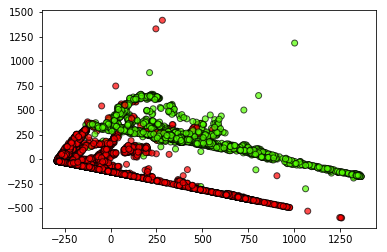

In [38]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

# Linear SVM

In [39]:
from sklearn.svm import LinearSVC

In [40]:
clf = LinearSVC(C=1.0, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(cross_val_score(clf, X, y))

/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy 0.9905010243993295
F1-score [0.99394802 0.97793163]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4235
           1       0.96      1.00      0.98      1134

    accuracy                           0.99      5369
   macro avg       0.98      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0.98524975 0.99312657 0.99580818]


/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [41]:
clf = LinearSVC(C=50.0, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(cross_val_score(clf, X, y))

/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy 0.9756006705159248
F1-score [0.98430198 0.945257  ]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4235
           1       0.90      1.00      0.95      1134

    accuracy                           0.98      5369
   macro avg       0.95      0.98      0.96      5369
weighted avg       0.98      0.98      0.98      5369



/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0.9562521  0.99312657 0.98809524]


/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [42]:
clf = LinearSVC(C=0.001, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(cross_val_score(clf, X, y))

/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy 0.9921773142112125
F1-score [0.99502134 0.981755  ]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4235
           1       0.97      1.00      0.98      1134

    accuracy                           0.99      5369
   macro avg       0.98      0.99      0.99      5369
weighted avg       0.99      0.99      0.99      5369



/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[0.98491452 0.99312657 0.96411804]


/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [43]:
decision_function = clf.decision_function(X_train)
support_vector_indices = np.where((2 * y_train - 1) * decision_function <= 1)[0]
support_vectors = X_train[support_vector_indices]

In [44]:
support_vectors_pca = pca.transform(support_vectors)

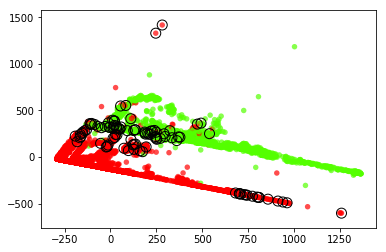

In [45]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='none', alpha=0.7, s=30)
plt.scatter(support_vectors_pca[:100, 0], support_vectors_pca[:100, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
plt.show()

## Effect of C

/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


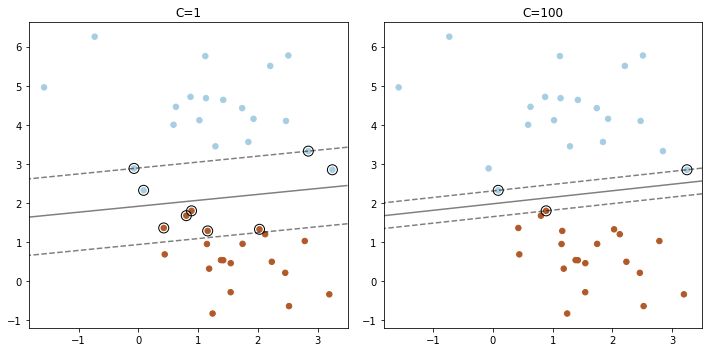

In [46]:
from sklearn.datasets import make_blobs
from sklearn.svm import LinearSVC

X, y = make_blobs(n_samples=40, centers=2, random_state=0)

plt.figure(figsize=(10, 5))
for i, C in enumerate([1, 100]):
    # "hinge" is the standard SVM loss
    clf = LinearSVC(C=C, loss="hinge", random_state=42).fit(X, y)
    # obtain the support vectors through the decision function
    decision_function = clf.decision_function(X)
    # we can also calculate the decision function manually
    # decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
    support_vector_indices = np.where((2 * y - 1) * decision_function <= 1)[0]
    support_vectors = X[support_vector_indices]

    plt.subplot(1, 2, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
                linewidth=1, facecolors='none', edgecolors='k')
    plt.title("C=" + str(C))
plt.tight_layout()
plt.show()

## Nonlinear SVM

In [47]:
from sklearn.svm import SVC

In [48]:
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(cross_val_score(clf, X, y))

Accuracy 0.9292233190538275
F1-score [0.95692587 0.80167015]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      4235
           1       0.98      0.68      0.80      1134

    accuracy                           0.93      5369
   macro avg       0.95      0.84      0.88      5369
weighted avg       0.93      0.93      0.92      5369

[1. 1. 1.]


/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [49]:
clf = SVC(gamma='auto', C=0.1, kernel='rbf', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(cross_val_score(clf, X, y))

Accuracy 0.788787483702738
F1-score [0.8819242 0.       ]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      4235
           1       0.00      0.00      0.00      1134

    accuracy                           0.79      5369
   macro avg       0.39      0.50      0.44      5369
weighted avg       0.62      0.79      0.70      5369

[1. 1. 1.]


/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [50]:
clf = SVC(gamma='auto', C=1, kernel='sigmoid', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.788787483702738
F1-score [0.8819242 0.       ]
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      4235
           1       0.00      0.00      0.00      1134

    accuracy                           0.79      5369
   macro avg       0.39      0.50      0.44      5369
weighted avg       0.62      0.79      0.70      5369



/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/marco/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [51]:
clf.support_

array([ 9228,  9230,  9234, ..., 12515, 12520, 12521], dtype=int32)

In [52]:
clf.support_vectors_[:10]

array([[2.07900000e+01, 0.00000000e+00, 1.30350000e+03, 1.70000000e+01,
        2.20000000e+01, 1.00000000e+00],
       [1.95000000e+01, 0.00000000e+00, 4.75333333e+02, 9.00000000e+00,
        8.00000000e+00, 1.00000000e+00],
       [1.97900000e+01, 0.00000000e+00, 5.05000000e+02, 1.40000000e+01,
        2.00000000e+00, 1.00000000e+00],
       [2.23900000e+01, 4.60000000e+01, 9.30500000e+02, 5.00000000e+00,
        1.30000000e+01, 1.00000000e+00],
       [1.96000000e+01, 1.35000000e+01, 4.54500000e+02, 7.00000000e+00,
        8.00000000e+00, 1.00000000e+00],
       [2.06000000e+01, 0.00000000e+00, 5.25666667e+02, 1.20000000e+01,
        1.00000000e+00, 1.00000000e+00],
       [1.97000000e+01, 0.00000000e+00, 4.45000000e+02, 7.00000000e+00,
        6.00000000e+00, 1.00000000e+00],
       [2.42900000e+01, 2.16000000e+02, 7.49666667e+02, 1.20000000e+01,
        1.30000000e+01, 1.00000000e+00],
       [1.98900000e+01, 0.00000000e+00, 5.29500000e+02, 1.40000000e+01,
        2.20000000e+01, 

In [53]:
clf.n_support_, len(X_train)

(array([2644, 2644], dtype=int32), 12526)

## Effect of Different Kernels

In [59]:


# fit the model
for kernel in ('linear', 'rbf', 'poly'):
    clf = SVC(kernel=kernel, gamma=10)
    clf.fit(X_train, y_train)

    plt.figure()
    plt.clf()
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired,
                edgecolor='k', s=20)

    # Circle out the test data
    plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none',
                zorder=10, edgecolor='k')

    plt.axis('tight')
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

    plt.title(kernel)
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [55]:
df_conc.isnull.sum()

AttributeError: 'function' object has no attribute 'sum'

In [ ]:
X = X_train
y = y_train

X = X[y != 0, :2]
y = y[y != 0]

n_sample = len(X)

np.random.seed(0)
order = np.random.permutation(n_sample)
X = X[order]
y = y[order].astype(np.float)



n_sample = len(X)

np.random.seed(0)
order = np.random.permutation(n_sample)
X = X[order]
y = y[order].astype(np.float)

X_train = X[:int(.9 * n_sample)]
y_train = y[:int(.9 * n_sample)]
X_test = X[int(.9 * n_sample):]
y_test = y[int(.9 * n_sample):]

In [67]:
for kernel in ('linear', 'rbf', 'poly'):
    clf = SVC(kernel=kernel, gamma=10)
    clf.fit(X_train, y_train)

    plt.figure()
    plt.clf()
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=10, cmap=plt.cm.Paired,
                edgecolor='k', s=20)

    # Circle out the test data
    plt.scatter(X_test[:, 0], X_test[:, 1], s=80, facecolors='none',
                zorder=10, edgecolor='k')

    plt.axis('tight')
    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

    plt.title(kernel)
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').